In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import sys
import scipy.sparse.linalg

sys.path.append('..')

from src.ham_to_sparse_matrix import *
from src.constants import *
from src.matrix_to_ps import *
from src.binary_encodings import *

In [3]:
bosonNI=sp.expand( pn**2/(2*aLat) + (aLat/2)*((qnP1-qnM1)/(2*aLat))**2 )
bosonI=sp.expand( (aLat/2)*V(qn)**2 + aLat*V(qn)*(qnP1-qnM1)/(4*aLat) + aLat*(qnP1-qnM1)*V(qn)/(4*aLat) )
fermionNI=sp.expand( -(xdnP1*xn+xdn*xnP1)/(2*aLat) )
fermionI=sp.expand( sp.diff(V(qn),qn)*(xdn*xn-(1/2)) )

In [4]:
N=2
aVal=1

# depends on finite-difference method
qs=[SiteSymbol('q',str(i)) for i in range(-1,N+1,1)]
# maybe make qs a normal site list
# and make an extra boundaryQs list for q[-1], q[N]
# counting would be normal computer science way for rest of code.

ps=[SiteSymbol('p',str(i)) for i in range(-1,N+1,1)] # don't really need extras
aops=[SiteSymbol('a',str(i)) for i in range(-1,N+1,1)]
adags=[SiteSymbol('a^{\dagger}',str(i)) for i in range(-1,N+1,1)]
xs=[SiteSymbol('\chi',str(i)) for i in range(-1,N+1,1)]
xdags=[SiteSymbol('\chi^{\dagger}',str(i)) for i in range(-1,N+1,1)]

# note this is exactly hardcoded for this finite difference method.
bcType = 'dirichlet'
boundaryConditions = {}
if bcType == 'periodic':
    boundaryConditions = {qs[0]: qs[N], qs[N+1]: qs[1],
                          xs[0]: -xs[N], xs[N+1]: -xs[1], 
                          xdags[0]: -xdags[N],  xdags[N+1]: -xdags[1]
                         }
    
elif bcType == 'dirichlet':
    boundaryConditions = { qs[0]: 0, qs[N+1]: 0,
                          xs[0]: 0, xs[N+1]: 0,
                          xdags[0]: 0, xdags[N+1]:0
                         }

In [5]:
ham=0

mass=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    # m*q with m=1
    return -mass*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

\chi^{\dagger}_{0}*\chi_{0} - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 - \chi^{\dagger}_{1}*\chi_{1} + p_{0}**2/2 + p_{1}**2/2 + 5*q_{0}**2/8 + 5*q_{1}**2/8

In [6]:
m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

\chi^{\dagger}_{0}*\chi_{0} - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 - \chi^{\dagger}_{1}*\chi_{1} + 9*a^{\dagger}_{0}*a_{0}/16 + a^{\dagger}_{0}**2/16 + 9*a^{\dagger}_{1}*a_{1}/16 + a^{\dagger}_{1}**2/16 + 9*a_{0}*a^{\dagger}_{0}/16 + a_{0}**2/16 + 9*a_{1}*a^{\dagger}_{1}/16 + a_{1}**2/16

In [48]:
from src.qiskit_utilities import *
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes

from qiskit import BasicAer

from qiskit import qpy
from src.timer import *

import pickle

from qiskit import QuantumCircuit, transpile


## Runs

In [52]:
cutoff=6
print("--------- Lambda = ", cutoff, " ----------")
t=Timer("hamMat")
t.start()
hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
t.stop()
t=Timer("Solve eigensystem")
t.start()
ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
t.stop()

t=Timer("Make pauli string ham")
t.start()
ps=matrix_to_pauli_strings(hamMat,standard_encode)
t.stop()
t=Timer("Make qiskit op")
t.start()
op = pauli_string_to_op(ps)
t.stop()

t=Timer("new new op")
t.start()
op3 = new_matrix_to_op(hamMat, standard_encode)
t.stop()

print(op)
print()
print(op3)

--------- Lambda =  6  ----------
hamMat timer took: 0.3441 seconds
Solve eigensystem timer took: 0.0032 seconds
OLD METHOD-VERYSLOW
Make pauli string ham timer took: 48.7120 seconds
Make qiskit op timer took: 0.5156 seconds
new new op timer took: 13.5679 seconds
9.313225746154785e-10 * IZIZIIII
+ 9.313225746154785e-10 * IZIZIIIZ
+ 9.313225746154785e-10 * IZIZIZZI
+ 9.313225746154785e-10 * IZIZIZZZ
+ 9.313225746154785e-10 * ZIZIIIII
+ 9.313225746154785e-10 * ZIZIIIIZ
+ 9.313225746154785e-10 * ZIZIIIZI
+ 9.313225746154785e-10 * ZIZIIIZZ
+ 9.313225746154785e-10 * ZIZIIZII
+ 9.313225746154785e-10 * ZIZIIZIZ
+ 9.313225746154785e-10 * ZIZIIZZI
+ 9.313225746154785e-10 * ZIZIIZZZ
+ 9.313225746154785e-10 * ZIZZZIII
+ 9.313225746154785e-10 * ZIZZZIIZ
+ 9.313225746154785e-10 * ZIZZZIZI
+ 9.313225746154785e-10 * ZIZZZIZZ
+ 9.313225746154785e-10 * ZIZZZZII
+ 9.313225746154785e-10 * ZIZZZZIZ
+ 9.313225746154785e-10 * ZIZZZZZI
+ 9.313225746154785e-10 * ZIZZZZZZ
+ 9.313225746154785e-10 * ZZZIZIII
+ 9

In [47]:
from qiskit.opflow import I,X,Y,Z,Zero


print(((X^I^X)+(Y^I^Y)+(X^I^X)).reduce())
print(2.0*X + 1.5*X)

2.0 * XIX
+ 1.0 * YIY
3.5 * X


In [55]:
for cutoff in [2,4,6,8]:
    print("--------- Lambda = ", cutoff, " ----------")
    t=Timer("hamMat")
    t.start()
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    t.stop()
    t=Timer("Sovel eigensystem")
    t.start()
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    t.stop()

    t=Timer("Make qiskit op")
    t.start()
    op = new_matrix_to_op(hamMat, standard_encode)
    t.stop()
    with open("Data/op_quad_cm0p2_lambda{}.pickle".format(cutoff), "wb") as f:
        pickle.dump(op, f)

    nq=math.floor(math.log2(hamMat.shape[0]))
    if not math.log2(hamMat.shape[0]).is_integer():
        nq+=1


    t=Timer("Run vqe")
    t.start()
    ansatz = RealAmplitudes(nq, reps=cutoff)    
    backend = BasicAer.get_backend("statevector_simulator")
    vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=backend)
    results=[]
    for i in range(10):
        results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
    t.stop()
    print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))

    t=Timer("Get trotter gate count")
    t.start()
    qc = QuantumCircuit(nq,nq)
    qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
    tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
    t.stop()
    print("gates for one trotter step = ", tmp.count_ops().get('cx'))

--------- Lambda =  2  ----------
hamMat timer took: 0.0939 seconds
Sovel eigensystem timer took: 0.0007 seconds
Make qiskit op timer took: 0.0413 seconds
Run vqe timer took: 11.5960 seconds
2 & 6.97e-03 & 6.97e-03 \\
Get trotter gate count timer took: 0.0215 seconds
gates for one trotter step =  6
--------- Lambda =  4  ----------
hamMat timer took: 0.1354 seconds
Sovel eigensystem timer took: 0.0016 seconds
Make qiskit op timer took: 0.8260 seconds
Run vqe timer took: 81.1395 seconds
4 & 3.22e-05 & 7.13e-05 \\
Get trotter gate count timer took: 0.5413 seconds
gates for one trotter step =  38
--------- Lambda =  6  ----------
hamMat timer took: 0.2336 seconds
Sovel eigensystem timer took: 0.0026 seconds
Make qiskit op timer took: 11.7095 seconds
Run vqe timer took: 167.2487 seconds
6 & 1.26e-07 & 2.35e-04 \\
Get trotter gate count timer took: 14.1128 seconds
gates for one trotter step =  7244
--------- Lambda =  8  ----------
hamMat timer took: 0.3645 seconds
Sovel eigensystem timer t

In [56]:
for cutoff in [16,12]:
    print("--------- Lambda = ", cutoff, " ----------")
    t=Timer("hamMat")
    t.start()
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    t.stop()
    t=Timer("Sovel eigensystem")
    t.start()
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    t.stop()

    t=Timer("Make qiskit op")
    t.start()
    op = new_matrix_to_op(hamMat, standard_encode)
    t.stop()
    with open("Data/op_quad_cm0p2_lambda{}.pickle".format(cutoff), "wb") as f:
        pickle.dump(op, f)

    nq=math.floor(math.log2(hamMat.shape[0]))
    if not math.log2(hamMat.shape[0]).is_integer():
        nq+=1


    t=Timer("Run vqe")
    t.start()
    ansatz = RealAmplitudes(nq, reps=cutoff)    
    backend = BasicAer.get_backend("statevector_simulator")
    vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=backend)
    results=[]
    for i in range(10):
        results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
    t.stop()
    print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))

    t=Timer("Get trotter gate count")
    t.start()
    qc = QuantumCircuit(nq,nq)
    qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
    tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
    t.stop()
    print("gates for one trotter step = ", tmp.count_ops().get('cx'))

--------- Lambda =  16  ----------
hamMat timer took: 1.5270 seconds
Sovel eigensystem timer took: 0.0308 seconds


KeyboardInterrupt: 

In [27]:
for cutoff in [2,4,6,8,10,12,14,16]:
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    print(np.min(ens).real)

--------- Lambda =  2  ----------
0.006966007
--------- Lambda =  4  ----------
3.22491e-05
--------- Lambda =  6  ----------
1.2604747e-07
--------- Lambda =  8  ----------
1.0418005e-09
--------- Lambda =  10  ----------
5.5398935e-10
--------- Lambda =  12  ----------
5.410267e-10
--------- Lambda =  14  ----------
5.401959e-10
--------- Lambda =  16  ----------
5.3902816e-10


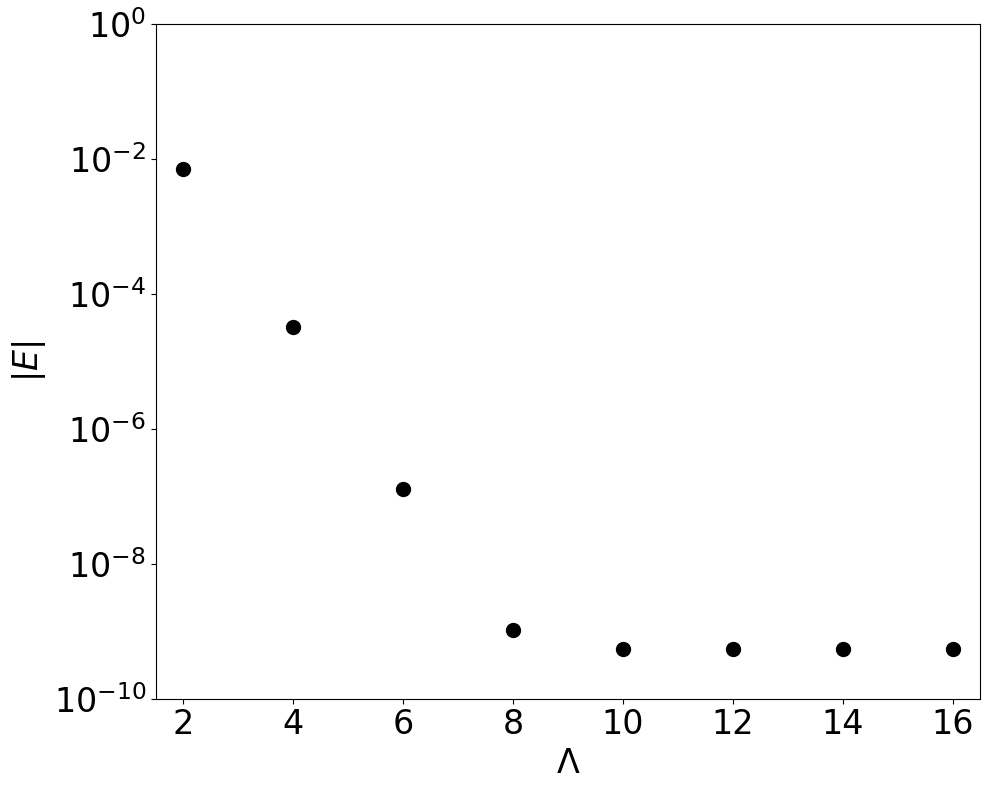

In [33]:
import matplotlib.pyplot as plt
import matplotlib 

ens=[0.006966007,3.22491e-05,1.2604747e-07,1.0418005e-09,5.5398935e-10,5.410267e-10,5.401959e-10,5.3902816e-10]

#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

fig, ax = plt.subplots()

plt.scatter([x for x in range(2,18,2)],[abs(en.real) for en in ens], c='black')
plt.yscale('log')

plt.xlabel('$\\Lambda$')
plt.ylabel('$|E|$')

plt.xlim(1.5,16.5)
plt.ylim(1e-10,1e0)
plt.yscale('log')

plt.savefig('Plots/WZ_2site_linear_classical.pdf',bbox_inches='tight')

## Better VQE

In [9]:
import os 

backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

vqeShots=100

for cutoff in [2,4,8]:
    print("Lambda={}  |  N={}  ".format(cutoff, N))
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]

    opFileName="Data/op_linear_lambda{}.pickle".format(cutoff)

    op=None
    if os.path.isfile(opFileName):
        print("reading op file")
        with open(opFileName, "rb") as f:
            op = pickle.load(f)

    else:
        print("computing op")
        ps=matrix_to_pauli_strings(hamMat,standard_encode)
        op = pauli_string_to_op(ps)

        with open(opFileName, "wb") as f:
            pickle.dump(op, f)


    nq=math.floor(math.log2(hamMat.shape[0]))
    if not math.log2(hamMat.shape[0]).is_integer():
        nq+=1

    ansatz = RealAmplitudes(nq, reps=cutoff)

        
    vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
    results=[]
    for i in range(vqeShots):
        results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)

    print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))

    qc = QuantumCircuit(nq,nq)
    qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
    tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
    print("gates for one trotter step = ", tmp.count_ops().get('cx'))

Lambda=2  |  N=2  
computing op
2 & 6.97e-03 & 6.97e-03 \\
gates for one trotter step =  8
Lambda=4  |  N=2  
computing op
4 & 3.22e-05 & 6.61e-05 \\
gates for one trotter step =  252
Lambda=8  |  N=2  
computing op
8 & 1.04e-09 & 1.35e-01 \\
gates for one trotter step =  2556


In [12]:
import os 

backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

vqeShots=1000

cutoff=8
print("Lambda={}  |  N={}  ".format(cutoff, N))
hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]

opFileName="Data/op_linear_lambda{}.pickle".format(cutoff)

op=None
if os.path.isfile(opFileName):
    print("reading op file")
    with open(opFileName, "rb") as f:
        op = pickle.load(f)

else:
    print("computing op")
    ps=matrix_to_pauli_strings(hamMat,standard_encode)
    op = pauli_string_to_op(ps)

    with open(opFileName, "wb") as f:
        pickle.dump(op, f)


nq=math.floor(math.log2(hamMat.shape[0]))
if not math.log2(hamMat.shape[0]).is_integer():
    nq+=1

ansatz = RealAmplitudes(nq, reps=cutoff)
print("running VQE")
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
results=[]
for i in range(vqeShots):
    results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)

print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))

Lambda=8  |  N=2  
reading op file
running VQE
8 & 1.04e-09 & 1.08e-01 \\
